CUDA device detected: NVIDIA L4
Total GPU Memory: 22.16 GB
Incorrect MM time (no sync): 0.5832 ms
Correct MM time (with sync): 1.2836 ms
Correct MM time (timeit, avg over 10 runs): 1.0801 ms
Time for matmul + .cpu() transfer: 3.9089 ms
Time for sum + .item(): 0.0453 ms
Sum result: -13279.021484375
Benchmarking with Warm-up:
Warm-up runs...
Measurement runs...
Average time over 10 measurement runs: 0.4783 ms
Standard deviation: 0.0033 ms
H2D Transfer Time (128 MB):
  Pageable Memory: 28.5886 ms
  Pinned Memory:   10.9343 ms
  Speedup:         2.61x

D2H Transfer Time (128 MB):
  To Pageable Memory: 26.6042 ms
  To Pinned Memory:   10.2439 ms
  Speedup:            2.60x
Benchmarking MatMul with varying sizes...
Running with cudnn.benchmark = False
Running with cudnn.benchmark = True


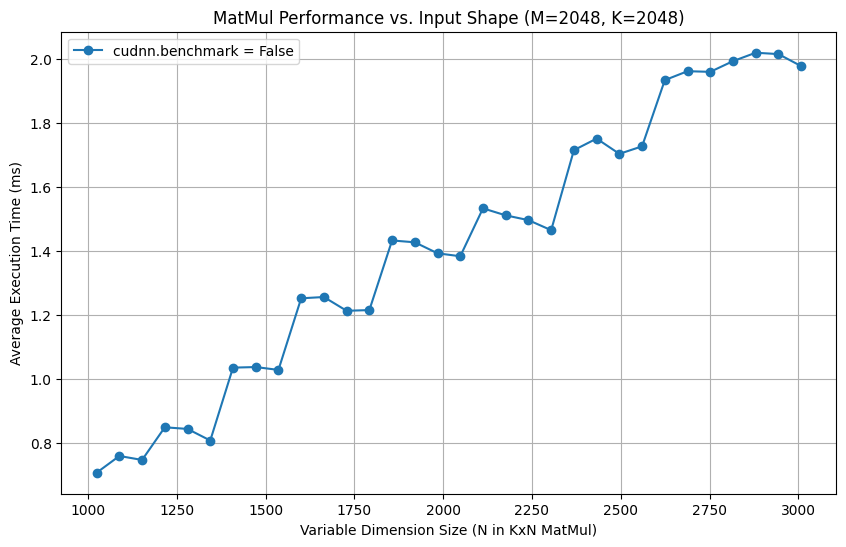


Note: Performance variations can be subtle and depend heavily on
the specific GPU, CUDA version, and operation.
The 'steps' or non-smoothness relate to Tile/Wave Quantization effects.
cudnn.benchmark=True is most effective for *fixed* input sizes.
Benchmarking MatMul with torch.utils.benchmark:
torch.matmul(a, b)
  1.25 ms
  1 measurement, 100 runs , 1 thread

Benchmarking with setup:
torch.matmul(x, y)
setup: x = torch.randn(s, s, device=dev); y = torch.randn(s, s, device=dev)
  1.36 ms
  1 measurement, 50 runs , 1 thread

Comparing implementations:
[------------------------ MatMul ------------------------]
                          |  Standard  |  Hypothetical Opt
1 threads: -----------------------------------------------
      torch.matmul(a, b)  |    1.4     |        1.4       

Times are in milliseconds (ms).

End of tutorial.


In [2]:
# -*- coding: utf-8 -*-
"""
Tutorial: Efficient Deep Learning Systems - Intro & Benchmarking

Based on the lecture by Max Ryabinin.
This notebook explores fundamental concepts of GPU execution and benchmarking
in PyTorch, relevant for building efficient DL systems.
"""

# %% [markdown]
# # Efficient Deep Learning Systems: Introduction & Benchmarking in PyTorch
#
# This notebook provides practical examples related to the introductory concepts covered in the "Efficient Deep Learning Systems" course. We'll touch upon:
#
# 1.  **GPU Architecture Basics (Briefly):** Understanding the high-level differences between CPU and GPU execution.
# 2.  **CUDA Execution Model:** How PyTorch interacts with the GPU (asynchronous execution).
# 3.  **Memory Access:** Host-to-Device (H2D) and Device-to-Host (D2H) transfers, and pinned memory.
# 4.  **Benchmarking:** How to measure performance correctly, considering synchronization and warm-up.
# 5.  **Input Shape Effects:** How performance can vary based on tensor dimensions (Tile/Wave Quantization effects).
# 6.  **PyTorch Utilities:** Using `torch.utils.benchmark`.
#
# **Prerequisites:**
# - PyTorch installed (`pip install torch torchvision torchaudio`)
# - A CUDA-enabled GPU recognized by PyTorch
# - `numpy` and `matplotlib` (`pip install numpy matplotlib`)

# %%
import torch
import numpy as np
import time
import matplotlib.pyplot as plt
import timeit

# %% [markdown]
# ## 1. Setup: Check GPU Availability
#
# First, let's verify that PyTorch can access the CUDA GPU.

# %%
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"CUDA device detected: {torch.cuda.get_device_name(0)}")
    print(f"Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.2f} GB")
else:
    device = torch.device("cpu")
    print("CUDA device not found, using CPU.")
    # Many examples below are GPU-specific, execution might fail or be slow.

# Ensure we have a GPU for the relevant parts
use_gpu = torch.cuda.is_available()

# %% [markdown]
# ## 2. GPU Architecture & Execution Model Basics (Conceptual Review)
#
# - **CPU vs. GPU:** CPUs have a few powerful cores optimized for serial tasks, with large caches. GPUs have thousands of simpler cores optimized for parallel tasks (SIMT - Single Instruction, Multiple Thread). (See Slide 9)
# - **CUDA Model:** PyTorch uses CUDA (or ROCm on AMD) to run operations (kernels) on the GPU. Work is launched from the host (CPU) to the device (GPU). Kernels are executed by threads, grouped into blocks, which form a grid. These blocks are scheduled onto Streaming Multiprocessors (SMs). (See Slide 10)
# - **Warps:** Threads execute in groups called warps (typically 32 threads). All threads in a warp execute the same instruction. Branching within a warp (where different threads take different paths) can reduce efficiency as all paths might need to be executed. (See Slide 11)
# - **Key Takeaway:** GPUs achieve speed through massive parallelism. Efficient code keeps these cores busy.

# %% [markdown]
# ## 3. Asynchronous Execution & Synchronization
#
# By default, CUDA operations (kernel launches, memory copies initiated from the CPU) are **asynchronous**. The CPU queues the operation and returns control immediately, *before* the GPU has finished. This hides latency and allows the CPU and GPU to work in parallel. (See Slide 16, 17)
#
# **Problem:** If we want to measure GPU execution time accurately, simply timing the Python call is wrong because it doesn't wait for the GPU to finish.
#
# **Solution:** We need to explicitly synchronize the CPU with the GPU using `torch.cuda.synchronize()`.

# %%
if use_gpu:
    # Example: Matrix Multiplication
    size = 2048
    a = torch.randn(size, size, device=device)
    b = torch.randn(size, size, device=device)

    # --- Incorrect Timing (No Synchronization) ---
    start_time = time.time()
    c = torch.matmul(a, b)
    end_time = time.time()
    print(f"Incorrect MM time (no sync): {(end_time - start_time) * 1000:.4f} ms")
    # This primarily measures kernel launch overhead, not execution time.

    # --- Correct Timing (With Synchronization) ---
    # We need to sync *before* starting and *after* finishing
    # to ensure the measured interval only contains the operation.
    torch.cuda.synchronize()  # Ensure previous work is done (optional here, but good practice)
    start_time = time.time()
    c = torch.matmul(a, b)
    torch.cuda.synchronize()  # Wait for matmul kernel to finish
    end_time = time.time()
    print(f"Correct MM time (with sync): {(end_time - start_time) * 1000:.4f} ms")

    # Using timeit (more robust for short durations)
    # Note: timeit runs the code multiple times. Synchronization is needed *within* the timed statement.
    stmt = "torch.matmul(a, b); torch.cuda.synchronize()"
    setup = "import torch; size=2048; device=torch.device('cuda'); torch.cuda.synchronize(); a = torch.randn(size, size, device=device); b = torch.randn(size, size, device=device); torch.cuda.synchronize()"
    num_runs = 10
    timer = timeit.Timer(stmt=stmt, setup=setup)
    avg_time_ms = timer.timeit(number=num_runs) / num_runs * 1000
    print(f"Correct MM time (timeit, avg over {num_runs} runs): {avg_time_ms:.4f} ms")

else:
    print("Skipping asynchronous execution demo (requires GPU).")

# %% [markdown]
# ### Synchronization Triggered by Data Transfer
#
# Copying data from GPU to CPU (e.g., using `.cpu()` or `.item()`) implicitly synchronizes the specific stream the tensor is on, as the CPU needs the result. (See Slide 17)

# %%
if use_gpu:
    size = 1024
    a_gpu = torch.randn(size, size, device=device)
    b_gpu = torch.randn(size, size, device=device)

    # Perform an operation
    c_gpu = torch.matmul(a_gpu, b_gpu)

    # Time the operation *plus* the copy back to CPU
    start_time = time.time()
    c_cpu = c_gpu.cpu() # This forces synchronization for c_gpu
    end_time = time.time()
    print(f"Time for matmul + .cpu() transfer: {(end_time - start_time) * 1000:.4f} ms")

    # Similarly, .item() on a 1-element tensor synchronizes
    result_gpu = torch.sum(c_gpu)
    start_time = time.time()
    result_val = result_gpu.item() # This forces synchronization for result_gpu
    end_time = time.time()
    print(f"Time for sum + .item(): {(end_time - start_time) * 1000:.4f} ms")
    print(f"Sum result: {result_val}") # The CPU now has the result

else:
    print("Skipping .cpu()/.item() sync demo (requires GPU).")


# %% [markdown]
# ## 4. Benchmarking Considerations: Warm-up
#
# The first time a CUDA operation runs, there might be extra overhead (e.g., kernel loading, context initialization, memory allocations). Subsequent runs are often faster. Therefore, it's crucial to perform "warm-up" runs before starting actual measurements. (See Slide 18)

# %%
if use_gpu:
    size = 1536
    a = torch.randn(size, size, device=device)
    b = torch.randn(size, size, device=device)

    print("Benchmarking with Warm-up:")

    # Warm-up runs
    print("Warm-up runs...")
    for _ in range(3):
        c = torch.matmul(a, b)
        torch.cuda.synchronize() # Ensure each warm-up completes

    # Actual measurement runs
    print("Measurement runs...")
    times = []
    num_runs = 10
    for _ in range(num_runs):
        torch.cuda.synchronize()
        start_time = time.time()
        c = torch.matmul(a, b)
        torch.cuda.synchronize()
        end_time = time.time()
        times.append((end_time - start_time) * 1000) # milliseconds

    print(f"Average time over {num_runs} measurement runs: {np.mean(times):.4f} ms")
    print(f"Standard deviation: {np.std(times):.4f} ms")

else:
    print("Skipping warm-up demo (requires GPU).")

# %% [markdown]
# ## 5. Memory Access: Host <-> Device Transfers & Pinned Memory
#
# Data must be explicitly copied between the CPU's RAM (host memory) and the GPU's RAM (device memory). These copies happen over the PCIe bus, which can be a bottleneck. (See Slide 14)
#
# - **H2D:** Host to Device (`.to(device)` or `.cuda()`)
# - **D2H:** Device to Host (`.cpu()`)
#
# Standard host memory allocated by Python/PyTorch is **pageable**. The OS can move it around in physical RAM or swap it to disk. CUDA transfers from pageable memory require an extra internal copy to a **pinned** (or page-locked) buffer before the transfer can start via DMA (Direct Memory Access).
#
# Allocating host memory as **pinned** avoids this extra copy, potentially speeding up H2D transfers. D2H transfers are often faster *into* pinned memory as well.
#
# **How to use pinned memory:**
# - Create a tensor directly in pinned memory: `torch.empty(..., pin_memory=True)`
# - Copy an existing CPU tensor to pinned memory: `cpu_tensor.pin_memory()`
# - Use `pin_memory=True` in `torch.utils.data.DataLoader`.

# %%
if use_gpu:
    size_bytes = 128 * 1024 * 1024  # 128 MB
    elements = size_bytes // 4 # Assuming float32 (4 bytes)
    cpu_tensor_pageable = torch.randn(elements, device='cpu')
    # Create a tensor directly in pinned memory
    cpu_tensor_pinned = torch.empty(elements, device='cpu', pin_memory=True)
    cpu_tensor_pinned.copy_(cpu_tensor_pageable) # Copy data into it

    # --- Benchmark H2D transfer ---
    num_runs = 10
    warmup = 2

    def benchmark_h2d(tensor):
        times = []
        # Warmup
        for _ in range(warmup):
            gpu_tensor = tensor.to(device)
            torch.cuda.synchronize()
        # Measure
        for _ in range(num_runs):
            torch.cuda.synchronize()
            start = time.time()
            gpu_tensor = tensor.to(device)
            torch.cuda.synchronize()
            end = time.time()
            times.append((end - start) * 1000) # ms
        del gpu_tensor # Free GPU memory
        torch.cuda.empty_cache()
        return np.mean(times)

    time_pageable = benchmark_h2d(cpu_tensor_pageable)
    time_pinned = benchmark_h2d(cpu_tensor_pinned)

    print(f"H2D Transfer Time ({size_bytes / (1024**2):.0f} MB):")
    print(f"  Pageable Memory: {time_pageable:.4f} ms")
    print(f"  Pinned Memory:   {time_pinned:.4f} ms")
    if time_pinned < time_pageable:
         print(f"  Speedup:         {time_pageable / time_pinned:.2f}x")
    else:
        print("  (No speedup observed in this run)")

    # --- Benchmark D2H transfer ---
    gpu_tensor = cpu_tensor_pageable.to(device) # Start with data on GPU

    def benchmark_d2h(target_cpu_tensor):
        times = []
         # Warmup
        for _ in range(warmup):
             target_cpu_tensor.copy_(gpu_tensor) # Copy D2H into target
             torch.cuda.synchronize() # Not strictly needed for D2H but good practice
        # Measure
        for _ in range(num_runs):
            # No sync needed before D2H usually, but sync *after* to ensure completion
            start = time.time()
            target_cpu_tensor.copy_(gpu_tensor)
            # Sync isn't strictly necessary for D2H timing itself,
            # as copy_ implies some level of sync, but let's be safe.
            torch.cuda.synchronize()
            end = time.time()
            times.append((end - start) * 1000)
        return np.mean(times)

    time_d2h_pageable = benchmark_d2h(torch.empty_like(cpu_tensor_pageable))
    time_d2h_pinned = benchmark_d2h(torch.empty_like(cpu_tensor_pinned, pin_memory=True))

    print(f"\nD2H Transfer Time ({size_bytes / (1024**2):.0f} MB):")
    print(f"  To Pageable Memory: {time_d2h_pageable:.4f} ms")
    print(f"  To Pinned Memory:   {time_d2h_pinned:.4f} ms")
    if time_d2h_pinned < time_d2h_pageable:
         print(f"  Speedup:            {time_d2h_pageable / time_d2h_pinned:.2f}x")
    else:
        print("  (No speedup observed in this run)")

    del gpu_tensor
    torch.cuda.empty_cache()

else:
    print("Skipping memory transfer demo (requires GPU).")

# %% [markdown]
# **Note on Pinned Memory:** Allocating too much pinned memory can degrade overall system performance because it reduces the amount of memory the OS can manage (e.g., page out). Use it judiciously, primarily for buffers involved in frequent H2D/D2H transfers (like in data loading pipelines).

# %% [markdown]
# ## 6. Input Shape Effects & `cudnn.benchmark`
#
# GPU performance, especially for operations like convolutions and matrix multiplications handled by libraries like cuDNN, can be sensitive to input tensor shapes (sizes, strides). (See Slides 12, 13)
#
# - **Tile/Wave Quantization:** Hardware resources (SMs, memory bandwidth) are often utilized most efficiently when problem sizes align well with the hardware's internal tiling or scheduling strategies. Performance might not scale smoothly and can sometimes exhibit step-like behavior as dimensions change.
# - **`torch.backends.cudnn.benchmark = True`:** This tells cuDNN to run benchmarks for different algorithms for the specific input sizes encountered during the *first* pass of an operation (like `nn.Conv2d`). It then caches the fastest algorithm for those specific sizes.
#
# **Use `cudnn.benchmark = True` if:**
# - Your input sizes (batch size, image dimensions, etc.) are **fixed** throughout training/inference.
#
# **Avoid `cudnn.benchmark = True` if:**
# - Your input sizes vary often (e.g., variable batch sizes, different image resolutions). The overhead of benchmarking each new size can outweigh the benefits. (See Slide 17)

# %%
if use_gpu and torch.backends.cudnn.is_available():
    print("Benchmarking MatMul with varying sizes...")
    fixed_dim = 2048
    variable_dims = list(range(1024, 3072, 64)) # Vary one dimension
    times_default = []
    times_benchmark_mode = []

    # --- Default Mode ---
    torch.backends.cudnn.benchmark = False
    print("Running with cudnn.benchmark = False")
    a = torch.randn(fixed_dim, fixed_dim, device=device) # Reusable tensor
    for dim in variable_dims:
        b = torch.randn(fixed_dim, dim, device=device)
        # Warmup
        for _ in range(2): torch.matmul(a, b); torch.cuda.synchronize()
        # Measure
        torch.cuda.synchronize()
        start = time.time()
        for _ in range(5): # Average over a few runs
            c = torch.matmul(a, b)
        torch.cuda.synchronize()
        end = time.time()
        times_default.append(((end - start) / 5) * 1000) # Avg time in ms
        del b, c # Free memory
        torch.cuda.empty_cache()

    # --- Benchmark Mode ---
    torch.backends.cudnn.benchmark = True
    # NOTE: In benchmark mode, the *first* time a size is seen incurs overhead.
    # Subsequent calls with the *same* size should be faster.
    # Our loop uses different sizes, so we might not see the full benefit here,
    # and might even see slowdown due to repeated benchmarking.
    # This mode is best when sizes are *constant*.
    print("Running with cudnn.benchmark = True")
    a = torch.randn(fixed_dim, fixed_dim, device=device) # Recreate to reset potential cache
    for dim in variable_dims:
        b = torch.randn(fixed_dim, dim, device=device)
        # Allow benchmark to run on first pass, then measure
        torch.cuda.synchronize()
        start = time.time()
        # The first call within the timing loop might trigger benchmarking
        for _ in range(5):
             c = torch.matmul(a, b)
        torch.cuda.synchronize()
        end = time.time()
        times_benchmark_mode.append(((end - start) / 5) * 1000) # Avg time in ms
        del b, c # Free memory
        torch.cuda.empty_cache()

    # --- Plotting ---
    plt.figure(figsize=(10, 6))
    plt.plot(variable_dims, times_default, label='cudnn.benchmark = False', marker='o')
    # Plot benchmark mode only if useful (might be noisy here)
    # plt.plot(variable_dims, times_benchmark_mode, label='cudnn.benchmark = True', marker='x')
    plt.xlabel("Variable Dimension Size (N in KxN MatMul)")
    plt.ylabel("Average Execution Time (ms)")
    plt.title("MatMul Performance vs. Input Shape (M=2048, K=2048)")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\nNote: Performance variations can be subtle and depend heavily on")
    print("the specific GPU, CUDA version, and operation.")
    print("The 'steps' or non-smoothness relate to Tile/Wave Quantization effects.")
    print("cudnn.benchmark=True is most effective for *fixed* input sizes.")

    # Reset benchmark mode
    torch.backends.cudnn.benchmark = False
else:
    print("Skipping cudnn.benchmark demo (requires GPU and cuDNN).")


# %% [markdown]
# ## 7. `torch.utils.benchmark`: A Better Tool for Microbenchmarking
#
# Manually handling warm-up, synchronization, and multiple runs is tedious and error-prone. PyTorch provides `torch.utils.benchmark` for more robust microbenchmarking. (See Slide 18)

# %%
try:
    import torch.utils.benchmark as benchmark
except ImportError:
    print("torch.utils.benchmark not available (requires recent PyTorch version).")
    benchmark = None

if use_gpu and benchmark:
    size = 2048
    a = torch.randn(size, size, device=device)
    b = torch.randn(size, size, device=device)
    stmt = "torch.matmul(a, b)"

    # Basic usage
    timer = benchmark.Timer(
        stmt=stmt,
        globals={'a': a, 'b': b}
    )

    # Run the benchmark
    measurement = timer.timeit(100) # Run stmt 100 times for timing

    # Print the results (includes mean, median, stddev)
    print("Benchmarking MatMul with torch.utils.benchmark:")
    print(measurement)

    # Example with setup and different threads
    timer_with_setup = benchmark.Timer(
        stmt="torch.matmul(x, y)",
        setup="x = torch.randn(s, s, device=dev); y = torch.randn(s, s, device=dev)",
        globals={'s': size, 'dev': device},
        num_threads=1 # Control CPU threads used by PyTorch (relevant for some ops)
    )
    measurement_setup = timer_with_setup.timeit(50)
    print("\nBenchmarking with setup:")
    print(measurement_setup)

    # Comparing two versions
    label = "MatMul"
    sub_label = f"{size}x{size}"
    results = []
    # Version 1 (standard)
    results.append(benchmark.Timer(stmt=stmt, globals={'a': a, 'b': b}, label=label, description="Standard").blocked_autorange())
    # Version 2 (let's pretend we optimize - e.g., fused op if available)
    # For demo, just run the same thing again
    results.append(benchmark.Timer(stmt=stmt, globals={'a': a, 'b': b}, label=label, description="Hypothetical Opt").blocked_autorange())

    compare = benchmark.Compare(results)
    print("\nComparing implementations:")
    compare.print()


else:
    if not benchmark:
         print("torch.utils.benchmark not imported.")
    else:
        print("Skipping torch.utils.benchmark demo (requires GPU).")


# %% [markdown]
# ## 8. Conclusion & Key Takeaways
#
# Understanding the basics of how code executes on a GPU is crucial for writing efficient deep learning systems.
#
# - **Asynchronous Execution:** Be aware of it and use `torch.cuda.synchronize()` for accurate timing.
# - **Memory Transfers:** Minimize H2D/D2H copies. Use pinned memory (`pin_memory=True`) strategically, especially in data loaders, to potentially speed up H2D transfers.
# - **Benchmarking:** Always perform warm-up runs. Use tools like `timeit` or preferably `torch.utils.benchmark` for reliable measurements.
# - **Input Shapes Matter:** Performance isn't always smooth. Be mindful of Tile/Wave quantization effects. Use `torch.backends.cudnn.benchmark = True` only when input shapes are constant.
# - **Don't Overoptimize Prematurely:** Profile your code to find the real bottlenecks before spending time on micro-optimizations (Slide 18). Focus on algorithmic improvements, data loading, and minimizing unnecessary work first.
#
# This introduction lays the groundwork for exploring more advanced topics like profiling, distributed training, and model optimization covered later in the course.

# %%
print("End of tutorial.")

In [8]:
import torch

torch.cuda.is_available()

True

In [9]:
torch.cuda.get_device_properties(0)


_CudaDeviceProperties(name='NVIDIA L4', major=8, minor=9, total_memory=22692MB, multi_processor_count=58, uuid=0363b84d-093e-e8eb-498e-07022b1f6e63, L2_cache_size=48MB)

In [10]:
def allocate_empty_tensor(dim_size):
    a = torch.empty(4096, dim_size, dtype=torch.float32, device="cuda")


In [11]:
allocate_empty_tensor(2048)


In [12]:
torch.cuda.memory_allocated(0)


54657536

In [13]:
torch.cuda.memory_reserved()


165675008

In [14]:
!nvidia-smi


Tue Apr 29 04:06:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   59C    P0             29W /   72W |     387MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [15]:
torch.cuda.empty_cache()
torch.cuda.memory_reserved()

81788928

In [16]:
!nvidia-smi

Tue Apr 29 04:07:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   60C    P0             30W /   72W |     307MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [17]:
allocate_empty_tensor(2048)
torch.cuda.memory_reserved()

115343360

In [18]:
allocate_empty_tensor(1024)
torch.cuda.memory_reserved()

115343360

In [19]:
allocate_empty_tensor(3072)
torch.cuda.memory_reserved()

165675008

In [20]:
memory_stats = torch.cuda.memory_stats()
print(memory_stats["active.all.allocated"])
print(memory_stats["active.all.current"])
print(memory_stats["active.all.peak"])
print(memory_stats["reserved_bytes.all.current"])

1321
7
17
165675008


In [21]:
torch.cuda.empty_cache()
print(torch.cuda.memory_stats()["reserved_bytes.all.current"])


81788928


In [22]:
def batched_dot_mul_sum(a, b):
    """Computes batched dot by multiplying and summing"""
    return a.mul(b).sum(-1)


def batched_dot_bmm(a, b):
    """Computes batched dot by reducing to bmm"""
    a = a.reshape(-1, 1, a.shape[-1])
    b = b.reshape(-1, b.shape[-1], 1)
    return torch.bmm(a, b).flatten(-3)


# Input for benchmarking
x = torch.randn(10000, 64)

# Ensure that both functions compute the same output
assert batched_dot_mul_sum(x, x).allclose(batched_dot_bmm(x, x))

In [23]:
import timeit

t0 = timeit.Timer(
    stmt="batched_dot_mul_sum(x, x)",
    setup="from __main__ import batched_dot_mul_sum",
    globals={"x": x},
)

t1 = timeit.Timer(
    stmt="batched_dot_bmm(x, x)",
    setup="from __main__ import batched_dot_bmm",
    globals={"x": x},
)

print(f"mul_sum(x, x):  {t0.timeit(100) / 100 * 1e6:>5.1f} us")
print(f"bmm(x, x):      {t1.timeit(100) / 100 * 1e6:>5.1f} us")

mul_sum(x, x):  136.8 us
bmm(x, x):      191.7 us


In [24]:
%timeit batched_dot_mul_sum(x, x)


77.7 µs ± 969 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [25]:
%timeit batched_dot_bmm(x, x)


164 µs ± 10.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [26]:
import torch.utils.benchmark as benchmark

t0 = benchmark.Timer(
    stmt="batched_dot_mul_sum(x, x)",
    setup="from __main__ import batched_dot_mul_sum",
    globals={"x": x},
)

t1 = benchmark.Timer(
    stmt="batched_dot_bmm(x, x)",
    setup="from __main__ import batched_dot_bmm",
    globals={"x": x},
)

print(t0.timeit(100))
print(t1.timeit(100))

batched_dot_mul_sum(x, x)
setup: from __main__ import batched_dot_mul_sum
  390.79 us
  1 measurement, 100 runs , 1 thread
batched_dot_bmm(x, x)
setup: from __main__ import batched_dot_bmm
  876.46 us
  1 measurement, 100 runs , 1 thread


In [27]:
# in addition, we can set the number of threads for CPU computations
num_threads = torch.get_num_threads()
print(f"Benchmarking on {num_threads} threads")

t0 = benchmark.Timer(
    stmt="batched_dot_mul_sum(x, x)",
    setup="from __main__ import batched_dot_mul_sum",
    globals={"x": x},
    num_threads=num_threads,
    label="Multithreaded batch dot",
    sub_label="Implemented using mul and sum",
)

t1 = benchmark.Timer(
    stmt="batched_dot_bmm(x, x)",
    setup="from __main__ import batched_dot_bmm",
    globals={"x": x},
    num_threads=num_threads,
    label="Multithreaded batch dot",
    sub_label="Implemented using bmm",
)

print(t0.timeit(100))
print(t1.timeit(100))

Benchmarking on 6 threads
Multithreaded batch dot: Implemented using mul and sum
setup: from __main__ import batched_dot_mul_sum
  81.66 us
  1 measurement, 100 runs , 6 threads
Multithreaded batch dot: Implemented using bmm
setup: from __main__ import batched_dot_bmm
  158.29 us
  1 measurement, 100 runs , 6 threads


In [28]:
# we can change it globally for PyTorch and measure the impact
prev_num_threads = num_threads
torch.set_num_threads(2)

num_threads = torch.get_num_threads()
print(f"Benchmarking on {num_threads} threads")

t0 = benchmark.Timer(
    stmt="batched_dot_mul_sum(x, x)",
    setup="from __main__ import batched_dot_mul_sum",
    globals={"x": x},
    num_threads=num_threads,
    label="Multithreaded batch dot",
    sub_label="Implemented using mul and sum",
)

t1 = benchmark.Timer(
    stmt="batched_dot_bmm(x, x)",
    setup="from __main__ import batched_dot_bmm",
    globals={"x": x},
    num_threads=num_threads,
    label="Multithreaded batch dot",
    sub_label="Implemented using bmm",
)

print(t0.timeit(100))
print(t1.timeit(100))
# in this case, we don't get any speedup, likely due to the overhead

torch.set_num_threads(prev_num_threads)


Benchmarking on 2 threads
Multithreaded batch dot: Implemented using mul and sum
setup: from __main__ import batched_dot_mul_sum
  206.36 us
  1 measurement, 100 runs , 2 threads
Multithreaded batch dot: Implemented using bmm
setup: from __main__ import batched_dot_bmm
  450.58 us
  1 measurement, 100 runs , 2 threads


In [29]:
# by the way, what CPU do we have?
!lscpu

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   12
  On-line CPU(s) list:    0-11
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:           6
    Model:                85
    Thread(s) per core:   2
    Core(s) per socket:   6
    Socket(s):            1
    Stepping:             7
    BogoMIPS:             4400.45
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge m
                          ca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht sysc
                          all nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xt
                          opology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq
                           ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt
                           aes xsave avx f16c rdrand hyperviso

In [30]:
import timeit

x = torch.randn(10000, 1024, device="cuda")

t0 = timeit.Timer(
    stmt="batched_dot_mul_sum(x, x)",
    setup="from __main__ import batched_dot_mul_sum",
    globals={"x": x},
)

t1 = timeit.Timer(
    stmt="batched_dot_bmm(x, x)",
    setup="from __main__ import batched_dot_bmm",
    globals={"x": x},
)

# Ran each twice to show difference before/after warmup
print(f"mul_sum(x, x):  {t0.timeit(100) / 100 * 1e6:>5.1f} us")
print(f"mul_sum(x, x):  {t0.timeit(100) / 100 * 1e6:>5.1f} us")
print(f"bmm(x, x):      {t1.timeit(100) / 100 * 1e6:>5.1f} us")
print(f"bmm(x, x):      {t1.timeit(100) / 100 * 1e6:>5.1f} us")

mul_sum(x, x):  292.4 us
mul_sum(x, x):   23.5 us
bmm(x, x):      703.0 us
bmm(x, x):       24.6 us


In [31]:
t0 = benchmark.Timer(
    stmt="batched_dot_mul_sum(x, x)",
    setup="from __main__ import batched_dot_mul_sum",
    globals={"x": x},
)

t1 = benchmark.Timer(
    stmt="batched_dot_bmm(x, x)",
    setup="from __main__ import batched_dot_bmm",
    globals={"x": x},
)

# Run only once since benchmark module does warmup for us
print(t0.timeit(100))
print(t1.timeit(100))

batched_dot_mul_sum(x, x)
setup: from __main__ import batched_dot_mul_sum
  363.77 us
  1 measurement, 100 runs , 1 thread
batched_dot_bmm(x, x)
setup: from __main__ import batched_dot_bmm
  46.30 us
  1 measurement, 100 runs , 1 thread


In [3]:
# -*- coding: utf-8 -*-
"""
Concise Tutorial: PyTorch GPU Essentials & Benchmarking

Based on seminar_01.ipynb, focusing on core concepts for efficient GPU usage.
Covers asynchronous execution, memory management, benchmarking, streams,
graphs, and debugging tips.
"""

# %% [markdown]
# # PyTorch GPU Essentials & Benchmarking: A Concise Tutorial
#
# This tutorial covers fundamental concepts and best practices for working efficiently with PyTorch on CUDA-enabled GPUs. We'll explore:
#
# 1.  **Asynchronous Execution:** Understanding how PyTorch interacts with the GPU and why synchronization is crucial for timing.
# 2.  **Memory Management:** Basics of GPU memory, host-device transfers, and the caching allocator.
# 3.  **Benchmarking GPU Code:** Reliable methods using `torch.utils.benchmark`, including warmup.
# 4.  **Performance Features:** Using CUDA Streams for overlap and CUDA Graphs for reducing launch overhead.
# 5.  **Debugging Tips:** Locating errors in asynchronous GPU code.
#
# **Goal:** Equip you with practical knowledge to write faster and more memory-efficient PyTorch code on GPUs.

# %% [markdown]
# ## Setup: Imports and Device Check

# %%
import torch
import numpy as np
import time
from time import perf_counter
import torch.utils.benchmark as benchmark # Recommended tool

# Check for GPU availability and set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"CUDA device found: {torch.cuda.get_device_name(0)}")
    props = torch.cuda.get_device_properties(0)
    print(f"   Compute Capability: {props.major}.{props.minor}")
    print(f"   Total Memory: {props.total_memory / (1024**3):.2f} GB")
    print(f"   Multiprocessor Count: {props.multi_processor_count}")
else:
    device = torch.device("cpu")
    print("CUDA device not found. Using CPU (GPU examples will be skipped or run on CPU).")
    # Set a flag for conditional execution of GPU-specific cells
    use_gpu = False
    props = None # No properties available

if device.type == 'cuda':
    use_gpu = True

# %% [markdown]
# ## 1. Asynchronous Execution & Synchronization
#
# CUDA operations launched from Python (like kernel execution or memory copies) are typically **asynchronous**. The CPU queues the task on the GPU and immediately returns, *before* the task is finished. This allows CPU and GPU parallelism but complicates timing.
#
# **Problem:** Naively timing Python calls doesn't measure the actual GPU execution time.
#
# **Solution:** Use `torch.cuda.synchronize()` to make the CPU wait until all previously queued tasks on the GPU have completed.

# %%
if use_gpu:
    size = 2048
    a = torch.randn(size, size, device=device)
    b = torch.randn(size, size, device=device)

    # --- Incorrect Timing (No Synchronization) ---
    start_time = perf_counter()
    c = torch.matmul(a, b)
    end_time = perf_counter()
    print(f"Incorrect MM time (measures launch overhead): {(end_time - start_time) * 1000:.4f} ms")

    # --- Correct Timing (With Synchronization) ---
    # Ensure GPU is idle before starting timer
    torch.cuda.synchronize()
    start_time = perf_counter()
    c = torch.matmul(a, b)
    # Wait for matmul kernel to finish *before* stopping timer
    torch.cuda.synchronize()
    end_time = perf_counter()
    correct_time_ms = (end_time - start_time) * 1000
    print(f"Correct MM time (with sync): {correct_time_ms:.4f} ms")

    # Note: Copying data back to CPU (e.g., .cpu(), .item()) also implicitly synchronizes.
    start_time = perf_counter()
    loss = c.sum().item() # .item() forces sync
    end_time = perf_counter()
    print(f"Timing with implicit sync via .item(): {(end_time - start_time) * 1000:.4f} ms")
    print(f"Result (sum): {loss}")

else:
    print("Skipping async execution demo (requires GPU).")

# %% [markdown]
# **Key Takeaway:** Always use `torch.cuda.synchronize()` when manually timing GPU operations with tools like `time.perf_counter`. Better yet, use benchmarking utilities that handle this automatically.

# %% [markdown]
# ## 2. Memory Management
#
# GPUs have their own memory (device memory), separate from CPU RAM (host memory). Data must be explicitly transferred.
#
# - **H2D (Host-to-Device):** `tensor.to(device)` or `tensor.cuda()`
# - **D2H (Device-to-Host):** `tensor.cpu()`
#
# These transfers occur over the PCIe bus and can be bottlenecks.
#
# ### Caching Allocator
# PyTorch uses a **caching allocator** for GPU memory to speed up allocations. When a tensor goes out of scope, its memory isn't immediately freed back to the OS but is kept **reserved** by PyTorch for potential reuse.
#
# - `torch.cuda.memory_allocated()`: Memory currently used by active tensors.
# - `torch.cuda.memory_reserved()`: Total memory held by the caching allocator (allocated + cached/free).

# %%
if use_gpu:
    print(f"Initial - Allocated: {torch.cuda.memory_allocated() / (1024**2):.2f} MB, Reserved: {torch.cuda.memory_reserved() / (1024**2):.2f} MB")

    # Allocate tensor inside a function scope
    def allocate_temp_tensor(rows, cols):
        t = torch.empty(rows, cols, device=device)
        print(f"Inside func - Allocated: {torch.cuda.memory_allocated() / (1024**2):.2f} MB, Reserved: {torch.cuda.memory_reserved() / (1024**2):.2f} MB")
        # Tensor 't' goes out of scope here

    allocate_temp_tensor(2048, 2048) # Approx 16 MB tensor
    print(f"After func - Allocated: {torch.cuda.memory_allocated() / (1024**2):.2f} MB, Reserved: {torch.cuda.memory_reserved() / (1024**2):.2f} MB")

    # Allocate another tensor (smaller) - should reuse the reserved block
    allocate_temp_tensor(1024, 1024) # Approx 4 MB tensor
    print(f"After smaller - Allocated: {torch.cuda.memory_allocated() / (1024**2):.2f} MB, Reserved: {torch.cuda.memory_reserved() / (1024**2):.2f} MB")

    # Allocate a larger tensor - may need a new block, increasing reserved memory
    allocate_temp_tensor(4096, 4096) # Approx 64 MB tensor
    print(f"After larger - Allocated: {torch.cuda.memory_allocated() / (1024**2):.2f} MB, Reserved: {torch.cuda.memory_reserved() / (1024**2):.2f} MB")

    # Manually clear the cache (releases reserved memory back to OS)
    # WARNING: This causes CPU-GPU synchronization and can hurt performance. Avoid frequent use.
    torch.cuda.empty_cache()
    print(f"After empty_cache - Allocated: {torch.cuda.memory_allocated() / (1024**2):.2f} MB, Reserved: {torch.cuda.memory_reserved() / (1024**2):.2f} MB")

else:
    print("Skipping memory management demo (requires GPU).")

# %% [markdown]
# **Memory Best Practices:**
# - Minimize H2D/D2H transfers.
# - Be mindful that reserved memory can grow if tensor sizes vary significantly. Pre-allocating for the largest expected size can sometimes help.
# - Avoid calling `torch.cuda.empty_cache()` frequently in performance-critical code. Better memory management is preferred.
# - Consider `pin_memory=True` for CPU tensors involved in frequent H2D transfers (e.g., in `DataLoader`) to potentially speed them up by avoiding an extra internal copy.

# %% [markdown]
# ## 3. Benchmarking GPU Code Reliably
#
# Accurate benchmarking requires:
# 1.  **Warmup:** Initial GPU operations can have extra overhead (context setup, kernel loading). Run the code a few times *before* measuring.
# 2.  **Synchronization:** Ensure measurements capture the full GPU execution time.
# 3.  **Averaging:** Run the operation multiple times and average the results for stability.
#
# `torch.utils.benchmark` is the recommended tool as it handles these aspects automatically.

# %%
# Define functions to benchmark (from original notebook)
def batched_dot_mul_sum(a, b):
    """Computes batched dot by multiplying and summing"""
    return a.mul(b).sum(-1)

def batched_dot_bmm(a, b):
    """Computes batched dot by reducing to bmm"""
    a = a.reshape(-1, 1, a.shape[-1])
    b = b.reshape(-1, b.shape[-1], 1)
    # Use .squeeze() instead of flatten for robustness if batch dim is 1
    return torch.bmm(a, b).squeeze(-1).squeeze(-1)

if use_gpu:
    # Input data on GPU
    x_gpu = torch.randn(10000, 1024, device=device)

    # Ensure correctness
    res1 = batched_dot_mul_sum(x_gpu, x_gpu)
    res2 = batched_dot_bmm(x_gpu, x_gpu)
    assert torch.allclose(res1, res2, atol=1e-5), "Functions produce different results!"

    print("Benchmarking with torch.utils.benchmark (handles warmup & sync):")

    t0 = benchmark.Timer(
        stmt="batched_dot_mul_sum(x, x)",
        globals={"x": x_gpu, "batched_dot_mul_sum": batched_dot_mul_sum}
    )

    t1 = benchmark.Timer(
        stmt="batched_dot_bmm(x, x)",
        globals={"x": x_gpu, "batched_dot_bmm": batched_dot_bmm}
    )

    # timeit runs the statement multiple times and returns measurement object
    m0 = t0.timeit(100)
    m1 = t1.timeit(100)

    print(f"Method 1 (mul_sum):\n{m0}")
    print(f"Method 2 (bmm):\n{m1}")

    # Comparing results
    compare = benchmark.Compare([m0, m1])
    print("\nComparison:")
    compare.print()

    # Quick check with IPython magic (also useful, handles basic timing)
    print("\nBenchmarking with %timeit magic:")
    %timeit batched_dot_mul_sum(x_gpu, x_gpu); torch.cuda.synchronize()
    %timeit batched_dot_bmm(x_gpu, x_gpu); torch.cuda.synchronize()

else:
    print("Skipping benchmarking demo (requires GPU).")

# %% [markdown]
# **Benchmarking Takeaway:** Use `torch.utils.benchmark` for reliable microbenchmarks. It handles warmup, synchronization, and provides statistical summaries. `%timeit` is convenient for quick checks in notebooks, but remember to add `torch.cuda.synchronize()` manually.

# %% [markdown]
# ## 4. Performance Features: Streams & Graphs
#
# ### CUDA Streams
# Streams allow **concurrent execution** of independent CUDA operations on the GPU, potentially overlapping computation with data transfers.
#
# **Use Case:** Overlap data loading/transfers (H2D) for the *next* batch with the computation of the *current* batch.

# %%
if use_gpu and props and props.major >= 3: # Streams generally effective on Kepler+
    # Setup: Heavy compute task (MatMul) and data to transfer
    compute_stream = torch.cuda.Stream()
    h2d_stream = torch.cuda.Stream()

    # Large matrix for compute-bound task
    A_gpu = torch.randn(8192, 8192, device=device)

    # List of CPU tensors to simulate data loading pipeline
    # Use pinned memory for potentially faster H2D transfers
    cpu_data = [torch.randn(2048, 2048, device='cpu').pin_memory() for _ in range(10)]
    gpu_targets = [torch.empty_like(d, device=device) for d in cpu_data] # Pre-allocate GPU targets

    # Ensure setup is complete
    torch.cuda.synchronize()

    # --- Sequential Execution (Compute then Transfer) ---
    start_seq = perf_counter()
    comp_result = torch.matmul(A_gpu, A_gpu)
    # Ensure compute is done before starting transfers (implicit if not using streams)
    torch.cuda.synchronize()
    transfer_start = perf_counter()
    for i in range(len(cpu_data)):
        gpu_targets[i].copy_(cpu_data[i], non_blocking=False) # Blocking copy
    # Ensure transfers are done
    torch.cuda.synchronize()
    end_seq = perf_counter()
    print(f"Sequential: Compute took ~{transfer_start - start_seq:.4f}s, Transfer took ~{end_seq - transfer_start:.4f}s, Total: {end_seq - start_seq:.4f}s")


    # --- Streamed Execution (Overlap Compute and Transfer) ---
    start_stream = perf_counter()
    # Queue computation on the compute stream
    with torch.cuda.stream(compute_stream):
        comp_result_stream = torch.matmul(A_gpu, A_gpu)

    # Queue transfers on the H2D stream
    with torch.cuda.stream(h2d_stream):
        for i in range(len(cpu_data)):
            # non_blocking=True is essential for overlap with other streams
            gpu_targets[i].copy_(cpu_data[i], non_blocking=True)

    # Wait for *both* streams to complete
    compute_stream.synchronize()
    h2d_stream.synchronize()
    # OR simply torch.cuda.synchronize() waits for all streams on the device
    # torch.cuda.synchronize()
    end_stream = perf_counter()
    print(f"Streamed (Overlap): Total time: {end_stream - start_stream:.4f}s")

    # Cleanup large tensor
    del A_gpu, comp_result, comp_result_stream
    torch.cuda.empty_cache()

else:
    print("Skipping CUDA Streams demo (requires GPU, preferably Compute Capability >= 3.0).")

# %% [markdown]
# **Streams Takeaway:** Streams can hide data transfer latency behind computation *if* the tasks are independent and the GPU isn't already fully saturated by one task alone. Use `non_blocking=True` for copies intended to overlap.

# %% [markdown]
# ### CUDA Graphs
# CUDA Graphs capture a sequence of GPU operations (kernel launches) and allow replaying them with very low CPU overhead.
#
# **Use Case:** Speeding up workloads dominated by **launching many small, fast kernels**, where the CPU overhead of launching each kernel becomes significant.

# %%
if use_gpu:
    # Function with many small operations
    def func_many_small_ops(x):
      for _ in range(200): # Reduced iterations for faster demo
        x = torch.sigmoid(x * 1.01 + 0.01) + torch.relu(x - 0.5)
      return x

    # Input for capture and replay
    static_input = torch.randn(1024, 1024, device=device)

    # --- Standard Eager Execution ---
    print("Benchmarking Eager Execution:")
    t_eager = benchmark.Timer(
        stmt="func_many_small_ops(x)",
        globals={"x": static_input, "func_many_small_ops": func_many_small_ops}
    )
    m_eager = t_eager.timeit(50)
    print(m_eager)


    # --- CUDA Graph Execution ---
    # 1. Warmup (Important before graph capture)
    # Run the function once to ensure kernels are loaded, etc.
    _ = func_many_small_ops(static_input)
    torch.cuda.synchronize()

    # 2. Capture
    graph = torch.cuda.CUDAGraph()
    # Create static tensors for capture inputs/outputs
    static_input_capture = static_input.clone()
    static_output_capture = torch.empty_like(static_input_capture)

    with torch.cuda.graph(graph):
        # Operations inside this block are captured
        static_output_capture = func_many_small_ops(static_input_capture)

    # 3. Replay
    # To run on new data, copy it into the original input tensor *before* replay
    new_data = torch.randn_like(static_input)
    static_input_capture.copy_(new_data)

    print("\nBenchmarking Graph Replay:")
    t_graph = benchmark.Timer(
        stmt="graph.replay()",
        # Setup includes copying new data before each replay measurement
        setup="static_input_capture.copy_(torch.randn_like(static_input))",
        globals={"graph": graph, "static_input_capture": static_input_capture, "torch": torch, "static_input": static_input}
    )
    m_graph = t_graph.timeit(50)
    print(m_graph)

    # Verify result (optional)
    # graph.replay() # Replay on the last copied data
    # eager_output = func_many_small_ops(static_input_capture.clone()) # Rerun eager on same data
    # print(f"\nGraph and Eager outputs close: {torch.allclose(static_output_capture, eager_output)}")

else:
    print("Skipping CUDA Graphs demo (requires GPU).")

# %% [markdown]
# **Graphs Takeaway:** CUDA Graphs significantly reduce CPU launch overhead for sequences of operations. Ideal for models or sections of code involving many small GPU tasks. Requires fixed operation sequence and careful handling of input/output tensors.

# %% [markdown]
# ## 5. Debugging Asynchronous Errors
#
# Because GPU execution is asynchronous, errors (like out-of-bounds access) might not be reported until a later synchronizing operation (`.item()`, `.cpu()`, `torch.cuda.synchronize()`). The Python traceback might point to the wrong line.
#
# **Solution:** Set the environment variable `CUDA_LAUNCH_BLOCKING=1` when running your script. This forces every CUDA operation to run synchronously, making the traceback point to the exact line causing the GPU error.
#
# ```bash
# # Example command line execution
# CUDA_LAUNCH_BLOCKING=1 python your_script.py
# ```
#
# Let's simulate this (requires saving and running a separate file).

# %%
# %%writefile gpu_error_example.py
import torch
import os

# Use GPU if available, otherwise skip gracefully
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Running on {device}")

    try:
        embedding = torch.nn.Embedding(10, 4).to(device)
        # Error: Index 10 is out of bounds for embedding size 10 (valid indices 0-9)
        bad_input = torch.tensor([[1, 2], [3, 10]], dtype=torch.long, device=device)

        print("Launching embedding lookup (potentially bad)...")
        embedded_vals = embedding(bad_input) # Error occurs here async

        print("Launching subsequent operation...")
        result = torch.sigmoid(embedded_vals) # Another async op

        print("Triggering synchronization via .sum().item()...")
        loss = result.sum().item() # Error likely reported here in default mode
        print(f"Loss (if successful): {loss}")

    except RuntimeError as e:
        print("\n--- Caught RuntimeError ---")
        print(e)
        # Check if the error message indicates a device-side assert
        if "device-side assert triggered" in str(e):
             print("\nSuggestion: Rerun with 'CUDA_LAUNCH_BLOCKING=1 python gpu_error_example.py' for a more precise traceback.")
        print("--- End of Error ---")

else:
    print("Skipping GPU error example (CUDA not available).")

print("Script finished.")

# %% [markdown]
# **Running the script normally (simulated output):**
# ```
# Running on cuda
# Launching embedding lookup (potentially bad)...
# Launching subsequent operation...
# Triggering synchronization via .sum().item()...
#
# --- Caught RuntimeError ---
# CUDA error: device-side assert triggered
# CUDA kernel errors might be asynchronously reported at some other API call, [...]
# Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
#
#
# Suggestion: Rerun with 'CUDA_LAUNCH_BLOCKING=1 python gpu_error_example.py' for a more precise traceback.
# --- End of Error ---
# Script finished.
# ```
# > Notice the error is caught near `.item()`, not the `embedding()` call.
#
# **Running with `CUDA_LAUNCH_BLOCKING=1` (simulated output):**
# ```
# Running on cuda
# Launching embedding lookup (potentially bad)...
#
# --- Caught RuntimeError ---
# CUDA error: device-side assert triggered
# Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
# --- End of Error ---
# Script finished.
# ```
# > With `CUDA_LAUNCH_BLOCKING=1`, the script would likely crash *during* the `embedding(bad_input)` call, giving a traceback pointing directly to that line. (Actual traceback varies).

# %% [markdown]
# **Debugging Takeaway:** If you get generic CUDA errors, rerun with `CUDA_LAUNCH_BLOCKING=1` to pinpoint the faulty operation. Remember to turn it off for regular training/inference as it hurts performance.

# %% [markdown]
# ## 6. Floating Point Precision
#
# Be aware that floating-point arithmetic is not always associative, and results can differ slightly between:
# - CPU vs. GPU execution
# - Different GPUs or CUDA versions
# - Different libraries (e.g., PyTorch vs. NumPy)
# - Even run-to-run on some hardware due to non-deterministic algorithms (though PyTorch tries to mitigate this).
#
# This is usually only problematic if your code relies on exact floating-point equality. For most DL tasks, small numerical differences are acceptable. `torch.allclose()` is useful for comparing tensors with tolerance.

# %%
torch.manual_seed(1337)
x_cpu = torch.randn(1000, 1000, dtype=torch.float32)
x_gpu = x_cpu.to(device)

def matrix_power_sum(x):
    # Use float64 for intermediate steps to reduce accumulation error magnitude for demo
    y = x.double() @ x.double() @ x.double() @ x.double() @ x.double() @ x.double()
    return y.sum().item()

if use_gpu:
    # Disable deterministic algorithms for this demo if enabled globally
    deterministic_setting = torch.are_deterministic_algorithms_enabled()
    torch.use_deterministic_algorithms(False)

    res_cpu = matrix_power_sum(x_cpu)
    res_gpu = matrix_power_sum(x_gpu)

    print(f"Result CPU: {res_cpu}")
    print(f"Result GPU: {res_gpu}")
    print(f"Difference: {abs(res_cpu - res_gpu)}")
    print(f"Relative Difference: {abs(res_cpu - res_gpu) / abs(res_cpu):.2e}")

    # Restore deterministic setting
    torch.use_deterministic_algorithms(deterministic_setting)
else:
    print("Skipping FP precision demo (requires GPU).")


# %% [markdown]
# ## Conclusion & Key Takeaways
#
# Efficiently using GPUs in PyTorch involves understanding their asynchronous nature and memory hierarchy.
#
# - **Synchronization is Key:** Use `torch.cuda.synchronize()` for manual timing; rely on `torch.utils.benchmark` which handles it automatically.
# - **Warmup Before Benchmarking:** Initial runs can be slower.
# - **Manage Memory:** Minimize host-device transfers. Use pinned memory strategically for H2D. Avoid frequent `empty_cache()`.
# - **Leverage Advanced Features:** Use CUDA Streams to overlap computation and data transfer. Use CUDA Graphs to reduce launch overhead for small kernels.
# - **Debug Smart:** Use `CUDA_LAUNCH_BLOCKING=1` to locate the source of asynchronous GPU errors.
# - **Be Aware of Precision:** Expect small floating-point differences across devices/runs.
#
# Applying these principles will help you build faster and more efficient deep learning systems.

# %%
print("End of tutorial.")

CUDA device found: NVIDIA L4
   Compute Capability: 8.9
   Total Memory: 22.16 GB
   Multiprocessor Count: 58
Incorrect MM time (measures launch overhead): 0.1014 ms
Correct MM time (with sync): 1.3654 ms
Timing with implicit sync via .item(): 0.1072 ms
Result (sum): -71633.71875
Initial - Allocated: 140.20 MB, Reserved: 178.00 MB
Inside func - Allocated: 156.20 MB, Reserved: 178.00 MB
After func - Allocated: 140.20 MB, Reserved: 178.00 MB
Inside func - Allocated: 144.20 MB, Reserved: 178.00 MB
After smaller - Allocated: 140.20 MB, Reserved: 178.00 MB
Inside func - Allocated: 204.20 MB, Reserved: 242.00 MB
After larger - Allocated: 140.20 MB, Reserved: 242.00 MB
After empty_cache - Allocated: 140.20 MB, Reserved: 156.00 MB
Benchmarking with torch.utils.benchmark (handles warmup & sync):
Method 1 (mul_sum):
batched_dot_mul_sum(x, x)
  364.62 us
  1 measurement, 100 runs , 1 thread
Method 2 (bmm):
batched_dot_bmm(x, x)
  46.25 us
  1 measurement, 100 runs , 1 thread

Comparison:


TypeError: object of type 'NoneType' has no len()